In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from moseq2_viz.util import read_yaml
from moseq2_viz.viz import _validate_and_order_syll_stats_params


In [2]:
moseq_df = pd.read_csv('./moseq_df.csv')
stats_df = pd.read_csv('./stats_df.csv')
max_syllables = 67 # explain 99% of the total frames
syll_info = read_yaml('./syll_info.yaml') # labeled from crowd movies

## Fig 6c

In [ ]:
moseq_df_subset = moseq_df.copy()
sessions = np.unique(moseq_df.uuid)

position_densities = []
groups = []
from scipy.signal import medfilt
for idx in sessions:
    moseq_df_session = moseq_df_subset[moseq_df_subset.uuid ==idx]
    groups.append(moseq_df_session.group.unique())
    position_density= plt.hist2d(moseq_df_session['centroid_x_px'], moseq_df_session['centroid_y_px'], bins = 100, density=False)
    position_densities.append(position_density[0]/position_density[0].sum())
position_densities = np.array(position_densities)
groups = np.concatenate(groups)

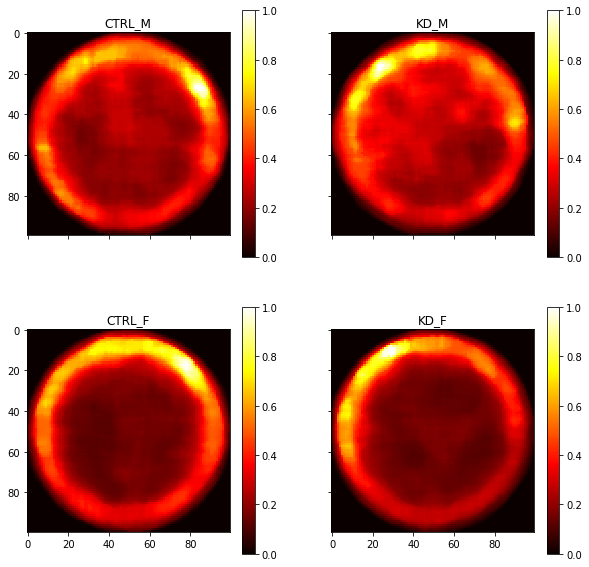

In [4]:
pd_cm =position_densities[np.where(groups =='CTRL_M')[0], :, :].mean(axis=0)
pd_cf = position_densities[np.where(groups =='CTRL_F')[0], :, :].mean(axis=0)
pd_kdm = position_densities[np.where(groups =='KD_M')[0], :, :].mean(axis=0)
pd_kdf = position_densities[np.where(groups =='KD_F')[0], :, :].mean(axis=0)

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

temp_density = position_densities[np.where(groups =='CTRL_M')[0], :, :].mean(axis=0)
temp_density = medfilt(temp_density, 11)
temp_density = (temp_density-temp_density.min())/(temp_density.max()-temp_density.min())

pos = axes[0].imshow(temp_density, cmap='hot')
axes[0].set_title('CTRL_M')
fig.colorbar(pos,ax=axes[0])

temp_density = position_densities[np.where(groups =='KD_M')[0], :, :].mean(axis=0)
temp_density = medfilt(temp_density, 11)
temp_density = (temp_density-temp_density.min())/(temp_density.max()-temp_density.min())

pos = axes[1].imshow(temp_density, cmap='hot')
axes[1].set_title('KD_M')
fig.colorbar(pos,ax=axes[1])

temp_density = position_densities[np.where(groups =='CTRL_F')[0], :, :].mean(axis=0)
temp_density = medfilt(temp_density, 11)
temp_density = (temp_density-temp_density.min())/(temp_density.max()-temp_density.min())
pos = axes[2].imshow(temp_density, cmap='hot')
axes[2].set_title('CTRL_F')
fig.colorbar(pos,ax=axes[2])

temp_density = position_densities[np.where(groups =='KD_F')[0], :, :].mean(axis=0)
temp_density = medfilt(temp_density, 11)
temp_density = (temp_density-temp_density.min())/(temp_density.max()-temp_density.min())
pos = axes[3].imshow(temp_density, cmap='hot')
axes[3].set_title('KD_F')
fig.colorbar(pos,ax=axes[3])

-1.5751783160877992 1.0850666471949628
-1.7390137982173346 2.4767757321300947


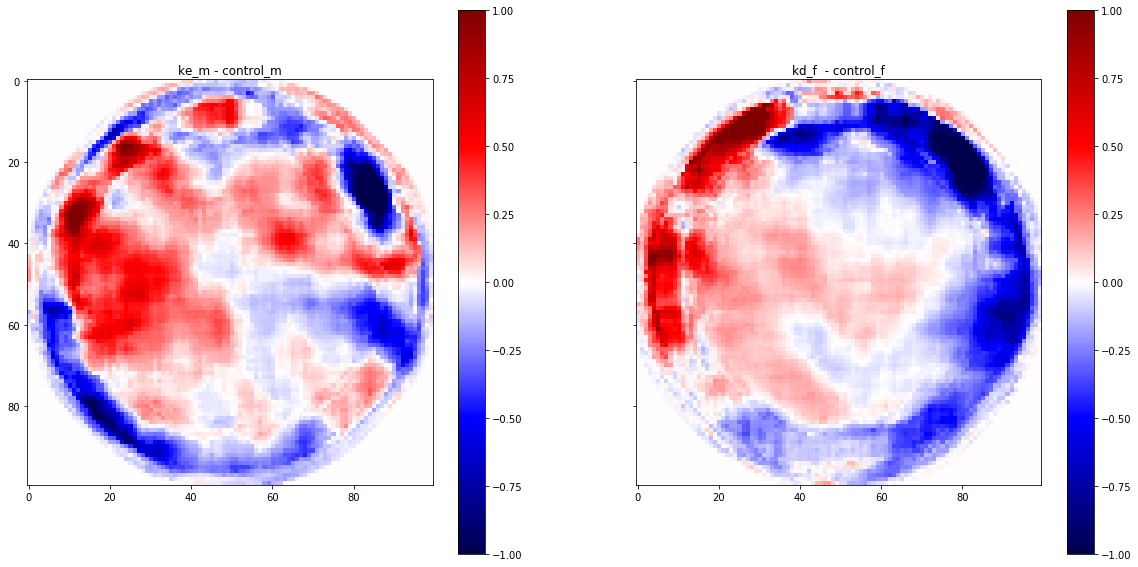

In [5]:
from scipy.signal import medfilt
from matplotlib.colors import DivergingNorm

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
vmin=0.00001
cmap = 'seismic'
axes = axes.flatten()
# scale the data to go from -1 to 1
data = (medfilt(pd_kdm, 11) - medfilt(pd_cm, 11))*10000
norm = DivergingNorm(vmin=data.min(), vcenter=0, vmax=data.max())
print(data.min(), data.max())
pos = axes[0].imshow(data, norm=norm, cmap = cmap, vmin = -1, vmax = 1)
axes[0].set_title('ke_m - control_m')
fig.colorbar(pos,ax=axes[0])
# scale the data to go from -1 to 1
data = (medfilt(pd_kdf, 11) - medfilt(pd_cf, 11))*10000
norm = DivergingNorm(vmin=data.min(), vcenter=0, vmax=data.max())
pos = axes[1].imshow(data, norm=norm, cmap = cmap, vmin = -1, vmax = 1)
axes[1].set_title('kd_f  - control_f')
fig.colorbar(pos,ax=axes[1])
print(data.min(), data.max())

## Fig 6d

In [6]:
def plot_syll_stats_with_sem_mgroup(scalar_df, syll_info=None, sig_sylls=None, stat='usage', ordering='stat', max_sylls=40, keys=[], groups=None, ctrl_group=None, 
                                    exp_group=None, colors=None, join=False,
                                    ci=None, ymin=None, ymax=None, figsize=(10, 5)):

    xlabel = f'Syllables sorted by {stat}'
    if ordering == 'diff':
        xlabel += f' difference ({ctrl_group} vs. {exp_group})'
        
    ordering, groups, colors, figsize = _validate_and_order_syll_stats_params(scalar_df,
                                                                              stat=stat,
                                                                              ordering=ordering,
                                                                              max_sylls=max_sylls,
                                                                              groups=groups,
                                                                              ctrl_group=ctrl_group,
                                                                              exp_group=exp_group,
                                                                              colors=colors,
                                                                              figsize=figsize)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # plot each group's stat data separately, computes groupwise SEM, and orders data based on the stat/ordering parameters
    hue = 'group' if groups is not None else None
    ax = sns.pointplot(data=scalar_df, x='syllable', y=stat, hue=hue, order=ordering,
                       join=join, dodge=True, ci=ci, ax=ax, hue_order=groups,
                       palette=colors)

    # where some data has already been plotted to ax
    handles, labels = ax.get_legend_handles_labels()

    # add syllable labels if they exist
    if syll_info is not None:
        mean_xlabels = []
        for o in (ordering):
            mean_xlabels.append(f'{syll_info[o]["label"]} - {o}')

        plt.xticks(range(max_sylls), mean_xlabels, rotation=90)
    
    init_y = -.003
    
    # single group
    if isinstance(sig_sylls, list):
        markings = []
        for s in sig_sylls:
            markings.append(ordering.index(s))
        plt.scatter(markings, [-.005] * len(markings), color='r', marker='*')

        # manually define a new patch
        patch = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                              markersize=9, label='Significant Syllable')
        handles.append(patch)
    # multi-group
    elif isinstance(sig_sylls, dict):
        for key in keys:
            markings = []
            for s in sig_sylls[key]:
                markings.append(ordering.index(s))
            plt.scatter(markings, [init_y] * len(markings), color='r', marker='*')
            plt.text(plt.xlim()[1], init_y, f'{key[0]} vs. {key[1]} - Total {len(sig_sylls[key])} S.S.')
            init_y += -.003

        # manually define a new patch
        patch = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                              markersize=9, label='Significant Syllable')
        handles.append(patch)

    # add legend and axis labels
    legend = ax.legend(handles=handles, frameon=False, bbox_to_anchor=(1, 1))
    
    plt.ylim(ymin, ymax) # usages y-axis (single group)
    
    plt.xlabel(xlabel, fontsize=12)
    sns.despine()

    return fig, legend

In [7]:
# Main plot

/n/groups/datta/sherry/moseq2-viz/moseq2_viz/viz.py:77: UserWarning: Number of inputted colors 0 does not match number of groups 2. Using default.
  warnings.warn(f'Number of inputted colors {len(colors)} does not match number of groups {len(groups)}. Using default.')


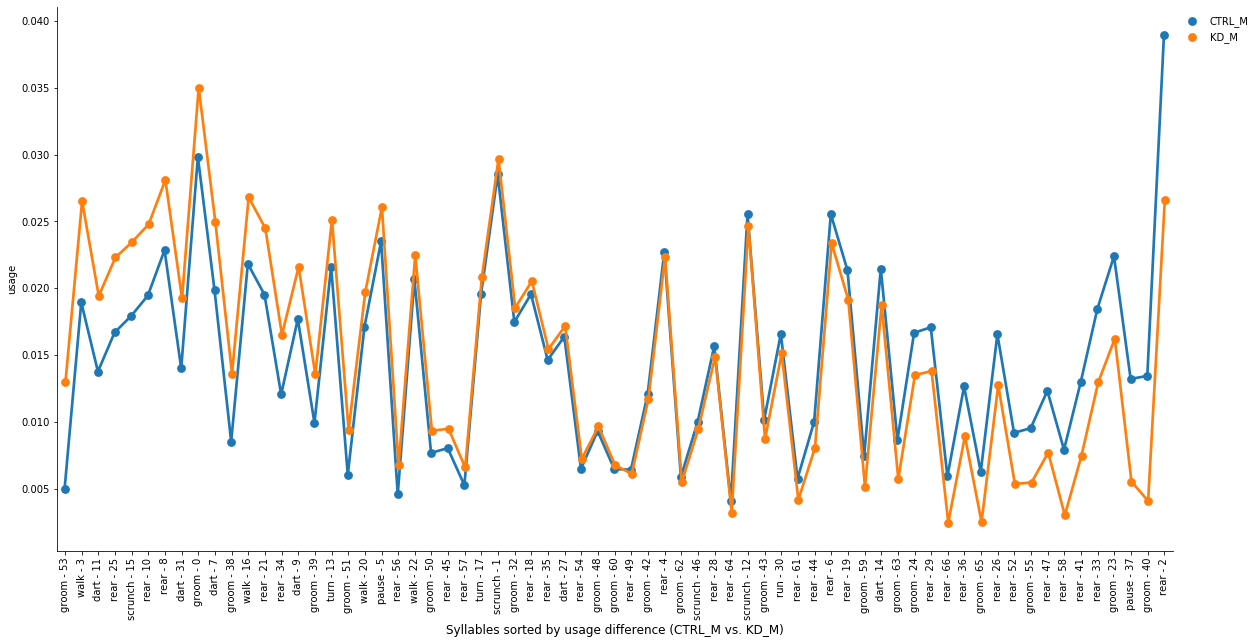

In [8]:
keys = [('CTRL_M', 'KD_M')]

fig, _ = plot_syll_stats_with_sem_mgroup(stats_df, 
                                syll_info=syll_info, # replace with syll_info variable if label dict was loaded
                                sig_sylls=None,
                                stat='usage', # choose any of the df columns
                                ordering='diff',
                                max_sylls=max_syllables,
                                groups=sorted(list(set(np.array(keys).ravel()))),
                                #groups=[group1, group2], # uncomment this line to only plot 2 groups (ensure to also comment previous groups parameter)
                                ctrl_group=keys[0][0],
                                exp_group=keys[0][1],
                                keys=keys,
                                colors=None,
                                join=True,
                                ci=None, # to plot confidence interval error bars, change None to an int between [0, 100]
                                ymin=None, # edit to change minimum plotted y-axis value
                                ymax=None, # edit to change maximum plotted y-axis value
                                figsize=(20,10))

/n/groups/datta/sherry/moseq2-viz/moseq2_viz/viz.py:77: UserWarning: Number of inputted colors 0 does not match number of groups 2. Using default.
  warnings.warn(f'Number of inputted colors {len(colors)} does not match number of groups {len(groups)}. Using default.')


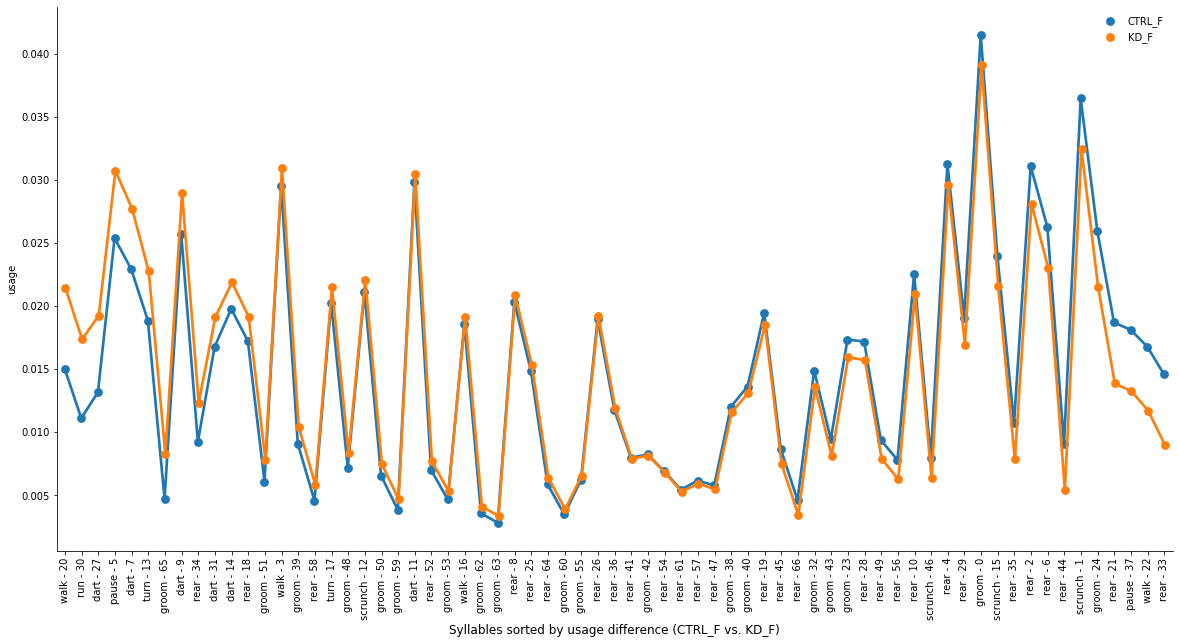

In [9]:
keys = [('CTRL_F', 'KD_F')]

fig, _ = plot_syll_stats_with_sem_mgroup(stats_df, 
                                syll_info=syll_info, # replace with syll_info variable if label dict was loaded
                                sig_sylls=None,
                                stat='usage', # choose any of the df columns
                                ordering='diff',
                                max_sylls=max_syllables,
                                groups=sorted(list(set(np.array(keys).ravel()))),
                                #groups=[group1, group2], # uncomment this line to only plot 2 groups (ensure to also comment previous groups parameter)
                                ctrl_group=keys[0][0],
                                exp_group=keys[0][1],
                                keys=keys,
                                colors=None,
                                join=True,
                                ci=None, # to plot confidence interval error bars, change None to an int between [0, 100]
                                ymin=None, # edit to change minimum plotted y-axis value
                                ymax=None, # edit to change maximum plotted y-axis value
                                figsize=(20,10))

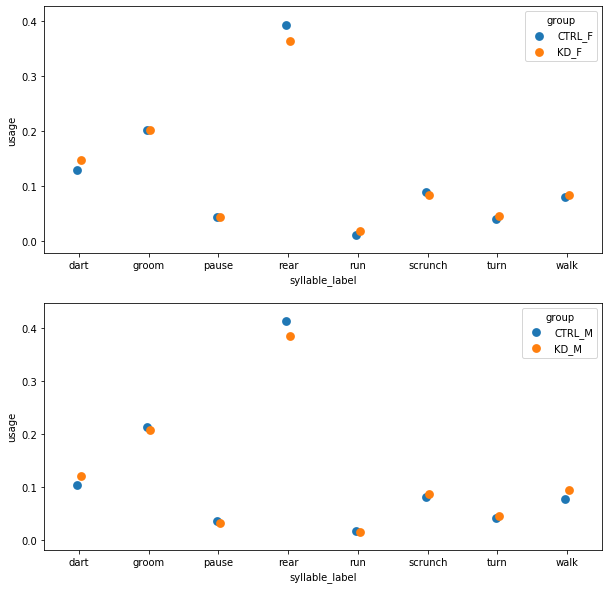

In [10]:
syll_info = read_yaml('./syll_info.yaml')
syll_dict = {k: v['label'] for k, v in syll_info.items()}
stats_df['syllable_label'] = stats_df['syllable'].map(syll_dict)

stats_df_clustered = stats_df.groupby(['uuid', 'group', 'syllable_label']).sum()['usage'].reset_index()
stats_df_clustered.head()

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes = axes.flatten()
sns.pointplot(data=stats_df_clustered, x='syllable_label', y='usage', hue='group',
                    join=False, dodge=True, ci=None, ax=axes[0], hue_order=['CTRL_F','KD_F'],
                    palette=sns.color_palette(n_colors=4))

sns.pointplot(data=stats_df_clustered, x='syllable_label', y='usage', hue='group',
                    join=False, dodge=True, ci=None, ax=axes[1], hue_order=['CTRL_M','KD_M'],
                    palette=sns.color_palette(n_colors=4))

## Fig 6e

(76, 67)
CTRL_F
CTRL_M
KD_F
KD_M
CTRL_F
CTRL_M
KD_F
KD_M


/home/shl490/miniconda3/envs/moseq2-dev/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


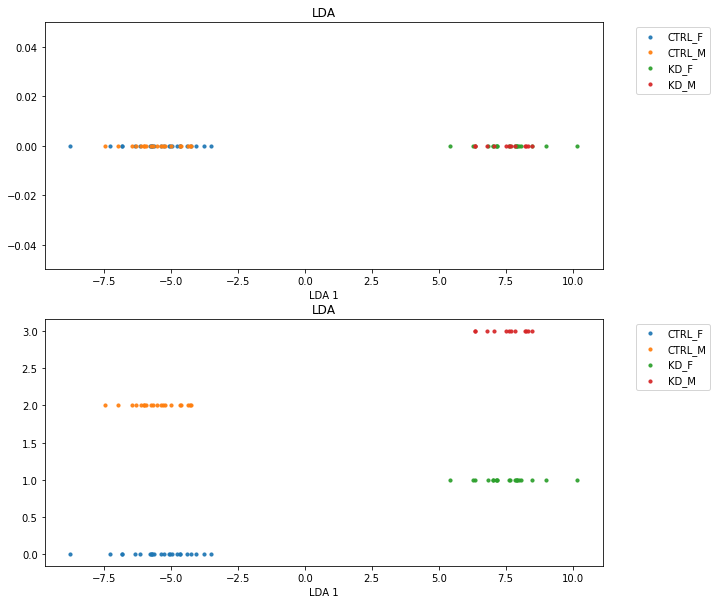

In [11]:
usage_df = stats_df[['uuid','syllable', 'usage','group']].copy()
usage_df = usage_df[usage_df.syllable < max_syllables]
index_data = usage_df[['uuid','group']].copy().drop_duplicates(subset='uuid')
usage_df = pd.pivot(usage_df, index='uuid', columns='syllable', values = 'usage')
usage_df = pd.merge(usage_df,  index_data, left_on = 'uuid', right_on='uuid', how = 'left')

plot_group = ['KD_F', 'CTRL_F', 'KD_M', 'CTRL_M']

usage_df_subset = usage_df[usage_df.group.isin(plot_group)].copy()
X = usage_df_subset.drop(['uuid', 'group'], axis=1).to_numpy()
print(X.shape)
y = usage_df_subset['group'].to_numpy()
target_names = np.unique(y)
lbl = np.array(['CTRL' if 'CTRL' in lbl else 'KD' for lbl in y])

lda = LinearDiscriminantAnalysis()
X_r2 = lda.fit(X, lbl).transform(X)

colors = sns.color_palette("tab10")

fig,axs = plt.subplots(2,1,figsize=(10,10))

for color, i, target_name in zip(colors, target_names, target_names):
    print(target_name)
    y_i = [0]
    # if i == 'CTRL_F':
    #     y_i = [0]
    # if i == 'KD_F':
    #     y_i = [1]
    # if i == 'CTRL_M':
    #     y_i = [2]
    # if i == 'KD_M':
    #     y_i = [3]
    x_i = X_r2[y == i]
    axs[0].scatter(
        x_i, y_i*len(x_i), alpha=0.9, color=color, label=target_name, s =10
    )
axs[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylim(0,0)
axs[0].set_xlabel('LDA 1')
axs[0].set_title("LDA")

for color, i, target_name in zip(colors, target_names, target_names):
    print(target_name)
    # y_i = [0]
    if i == 'CTRL_F':
        y_i = [0]
    if i == 'KD_F':
        y_i = [1]
    if i == 'CTRL_M':
        y_i = [2]
    if i == 'KD_M':
        y_i = [3]
    x_i = X_r2[y == i]
    axs[1].scatter(
        x_i, y_i*len(x_i), alpha=0.9, color=color, label=target_name, s =10
    )
axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

axs[1].set_xlabel('LDA 1')
axs[1].set_title("LDA")

plt.show()

## Fig 7f

In [12]:
# find prominent syllables
def lda_cv(X, y):
    keep = []
    predicted = []
    real = []
    for i in range(len(X)):
        X_leave = X[i,:]
        y_leave = y[i]
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i, axis=0)
        
        lda = LinearDiscriminantAnalysis()
        X_r2 = lda.fit(X_train, y_train).transform(X_train)
        keep.append(np.argsort(abs(lda.scalings_[:,0]))[::-1][:10])
        # CTRL mean
        ctrl_mean = np.mean(X_r2[y_train =='CTRL'])
        # KD mean
        kd_mean = np.mean(X_r2[y_train =='KD'])
        # transform leave one out
        X_leave_r2 = lda.transform(X_leave.reshape(1, -1))
        real.append(y_leave)
        dist_ctrl = abs(X_leave_r2 - ctrl_mean)
        dist_kd = abs(X_leave_r2 - kd_mean)
        
        if dist_ctrl < dist_kd:
            predicted.append('CTRL')
        else:
            predicted.append('KD')
    return keep, predicted, real

In [ ]:
usage_df = stats_df[['uuid','syllable', 'usage','group']].copy()
usage_df = usage_df[usage_df.syllable < max_syllables]
index_data = usage_df[['uuid','group']].copy().drop_duplicates(subset='uuid')
usage_df = pd.pivot(usage_df, index='uuid', columns='syllable', values = 'usage')
usage_df = pd.merge(usage_df,  index_data, left_on = 'uuid', right_on='uuid', how = 'left')

plot_group = ['KD_F', 'CTRL_F']

usage_df_subset = usage_df[usage_df.group.isin(plot_group)].copy()

X = usage_df_subset.drop(['uuid', 'group'], axis=1).to_numpy()
y = usage_df_subset['group'].to_numpy()
y = ['CTRL' if 'CTRL' in lbl else 'KD' for lbl in y]

f_keep, predicted, real = lda_cv(X, y)

plot_group = ['KD_M', 'CTRL_M']

usage_df_subset = usage_df[usage_df.group.isin(plot_group)].copy()

X = usage_df_subset.drop(['uuid', 'group'], axis=1).to_numpy()
y = usage_df_subset['group'].to_numpy()
y = ['CTRL' if 'CTRL' in lbl else 'KD' for lbl in y]

m_keep, predicted, real = lda_cv(X, y)

f_syll, syll_count = np.unique(np.concatenate(f_keep), return_counts=True)
f_syll = f_syll[np.argsort(syll_count)][::-1] # The red stars in Fig 6d(i)
m_syll, syll_count = np.unique(np.concatenate(m_keep), return_counts=True)
m_syll = m_syll[np.argsort(syll_count)][::-1] # The red stars in Fig 6d(ii)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix, accuracy_score

In [15]:
def create_balanced_dataset(clf_df):
    lbl, count = np.unique(clf_df.group, return_counts=True)
    max_lbl, min_lbl = lbl[np.argmax(count)], lbl[np.argmin(count)]
    subsample = np.random.choice(np.where(clf_df.group==max_lbl)[0], count.min(), replace=False)
    select = np.concatenate([subsample, np.where(clf_df.group==min_lbl)[0]])
    select_df = clf_df.iloc[select].copy()
    return select_df, select

In [16]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='Greys', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred,name):
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    return fig
    #fig.savefig(data_loc +name+'_decoder_confusion_shuffle.pdf', bbox_inches='tight')

In [ ]:
# male data
syll_include = m_syll
C=0.5 # found through grid search

y_true=[]
y_pred=[]
y_tshuff=[]
y_pshuff=[]

cv = LeaveOneOut()
clf_df_master = stats_df[stats_df.syllable.isin(syll_include)].copy()
clf_df_master = clf_df_master[clf_df_master.group.str.contains('_M')]
lbls= clf_df_master[['uuid', 'group']].drop_duplicates(subset=['uuid'])
clf_df_master = clf_df_master[['uuid','syllable', 'usage']].pivot(columns='syllable', index='uuid', values='usage')
clf_df_master = clf_df_master.merge(lbls, on='uuid')
print(clf_df_master.shape)

# subsample 10 times
np.random.seed(42)
for i in range(10):
    clf_df, _ = create_balanced_dataset(clf_df_master)
    y=list(clf_df.group.values)
    y = np.array(['CTRL' if 'CTRL' in lbl else 'KD' for lbl in y])
    # y = clf_df.group.values
    X=clf_df.drop(['uuid', 'group'], axis=1).values
    print(X.shape, y.shape)
    print(np.unique(y, return_counts=True))
    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # fit model
        # clf = RandomForestClassifier(n_estimators = 400,class_weight='balanced')
        # clf = make_pipeline(StandardScaler(), LinearSVC(random_state=42, C=C))
        clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, C=C))
        # clf = LinearSVC(random_state=42)
        clf.fit(X_train, y_train)
        # evaluate model
        yhat = clf.predict(X_test)
        # store
        y_true.append(y_test[0])
        y_pred.append(yhat[0])
        # calculate accuracy

    
    y_shuffle = np.copy(y)
    np.random.shuffle(y_shuffle)
    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y_shuffle[train_ix], y_shuffle[test_ix]
        # fit model
        # clf = RandomForestClassifier(n_estimators = 400,class_weight='balanced')
        # clf = make_pipeline(StandardScaler(), LinearSVC(random_state=42, C=C))
        clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, C=C))
        # clf = LinearSVC(random_state=42)
        clf.fit(X_train, y_train)
        # evaluate model
        yhat = clf.predict(X_test)
        # store
        y_tshuff.append(y_test[0])
        y_pshuff.append(yhat[0])
        # calculate accuracy

/home/shl490/miniconda3/envs/moseq2-dev/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


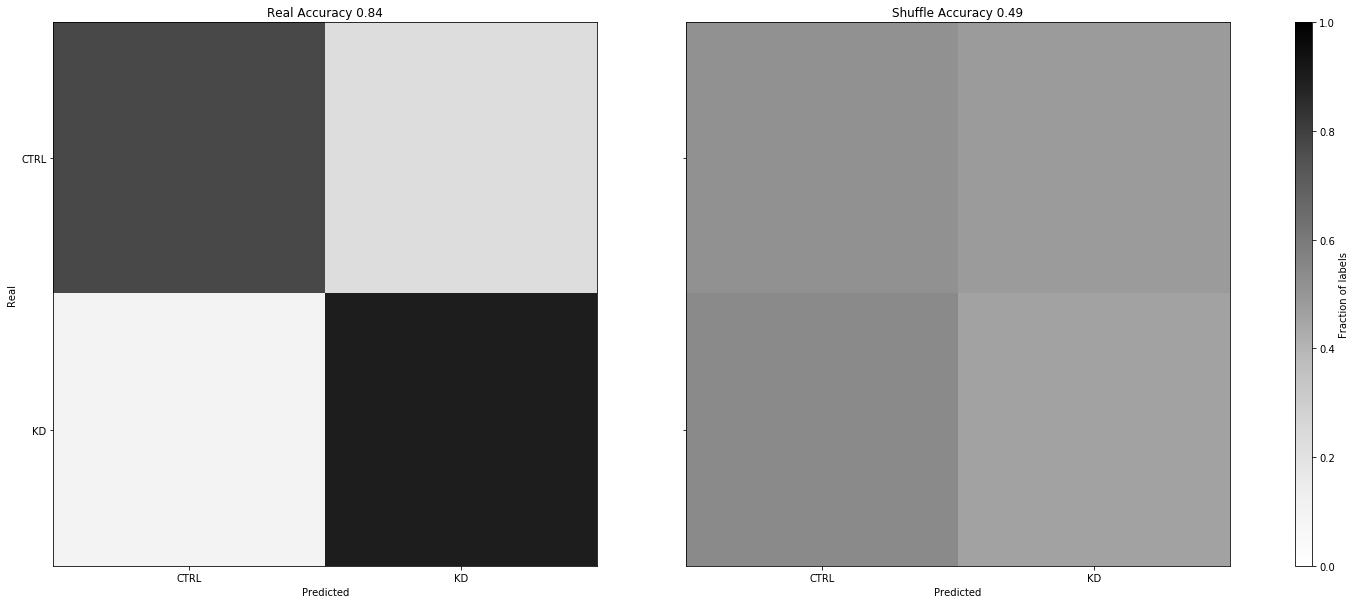

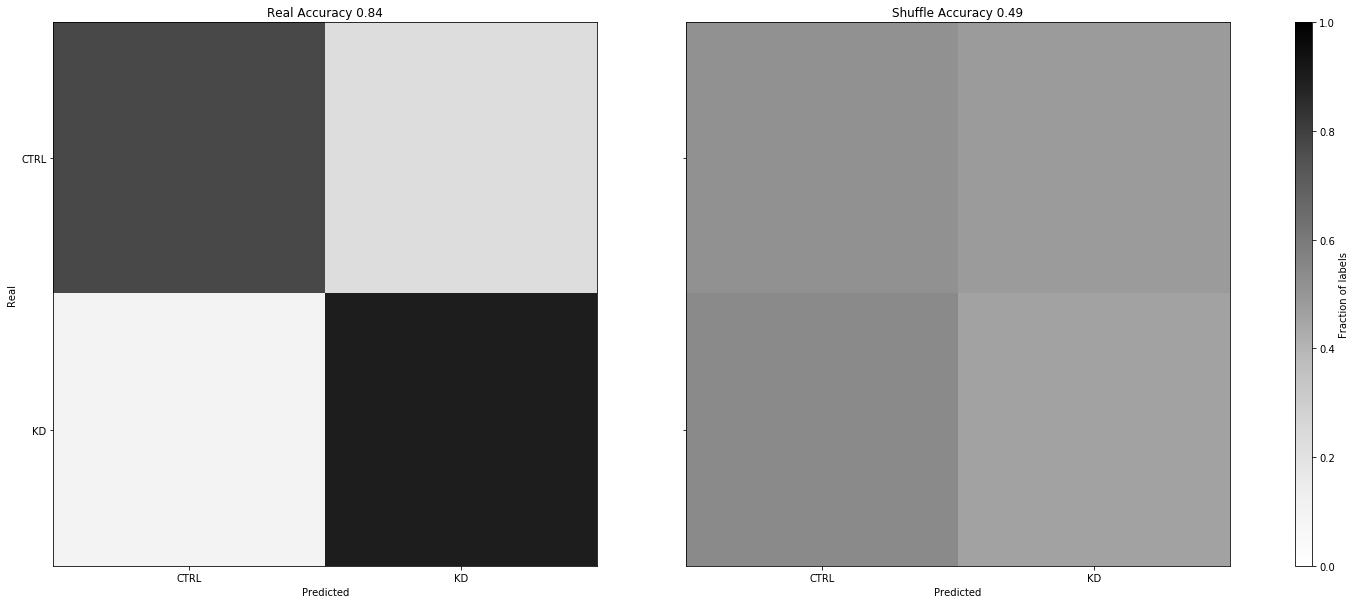

In [18]:
plot_cm(y_true, y_pred, y_tshuff, y_pshuff, 'logistic_regression')

In [ ]:
# female data
syll_include = f_syll
C=10 # found through grid search

y_true=[]
y_pred=[]
y_tshuff=[]
y_pshuff=[]

cv = LeaveOneOut()
clf_df_master = stats_df[stats_df.syllable.isin(syll_include)].copy()
clf_df_master = clf_df_master[clf_df_master.group.str.contains('_M')]
lbls= clf_df_master[['uuid', 'group']].drop_duplicates(subset=['uuid'])
clf_df_master = clf_df_master[['uuid','syllable', 'usage']].pivot(columns='syllable', index='uuid', values='usage')
clf_df_master = clf_df_master.merge(lbls, on='uuid')
print(clf_df_master.shape)

# subsample 10 times
np.random.seed(42)
for i in range(10):
    clf_df, _ = create_balanced_dataset(clf_df_master)
    y=list(clf_df.group.values)
    y = np.array(['CTRL' if 'CTRL' in lbl else 'KD' for lbl in y])
    # y = clf_df.group.values
    X=clf_df.drop(['uuid', 'group'], axis=1).values
    print(X.shape, y.shape)
    print(np.unique(y, return_counts=True))
    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # fit model
        # clf = RandomForestClassifier(n_estimators = 400,class_weight='balanced')
        # clf = make_pipeline(StandardScaler(), LinearSVC(random_state=42, C=C))
        clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, C=C))
        # clf = LinearSVC(random_state=42)
        clf.fit(X_train, y_train)
        # evaluate model
        yhat = clf.predict(X_test)
        # store
        y_true.append(y_test[0])
        y_pred.append(yhat[0])
        # calculate accuracy

    
    y_shuffle = np.copy(y)
    np.random.shuffle(y_shuffle)
    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y_shuffle[train_ix], y_shuffle[test_ix]
        # fit model
        # clf = RandomForestClassifier(n_estimators = 400,class_weight='balanced')
        # clf = make_pipeline(StandardScaler(), LinearSVC(random_state=42, C=C))
        clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, C=C))
        # clf = LinearSVC(random_state=42)
        clf.fit(X_train, y_train)
        # evaluate model
        yhat = clf.predict(X_test)
        # store
        y_tshuff.append(y_test[0])
        y_pshuff.append(yhat[0])
        # calculate accuracy

/home/shl490/miniconda3/envs/moseq2-dev/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


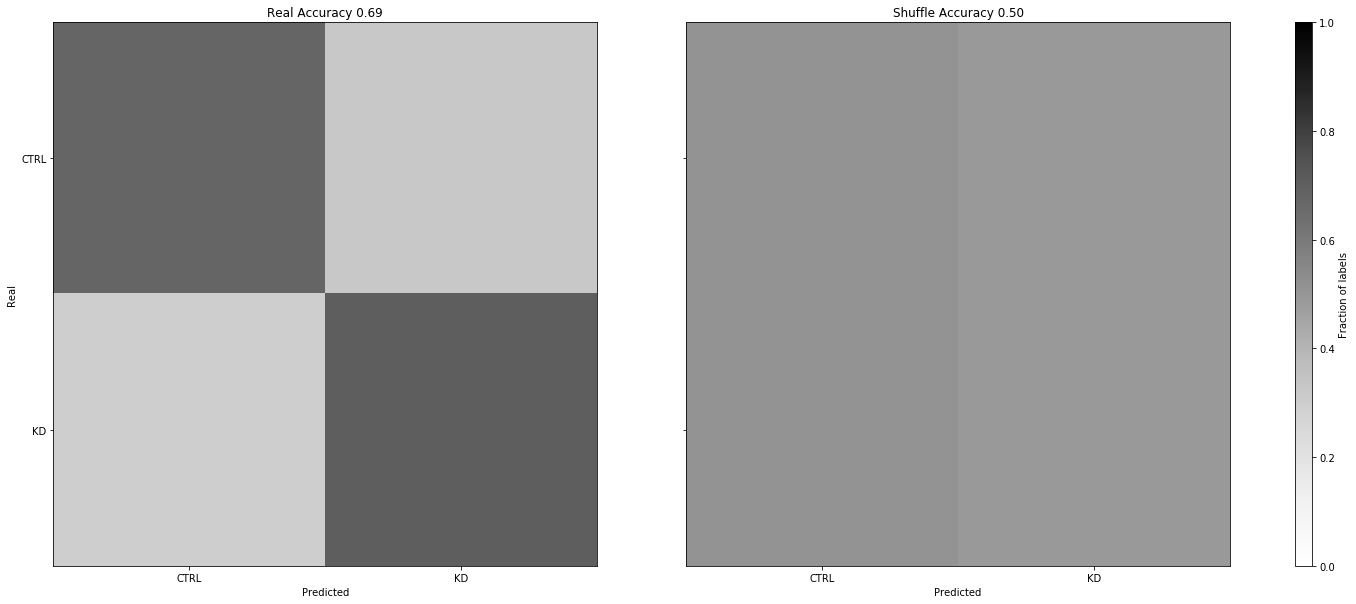

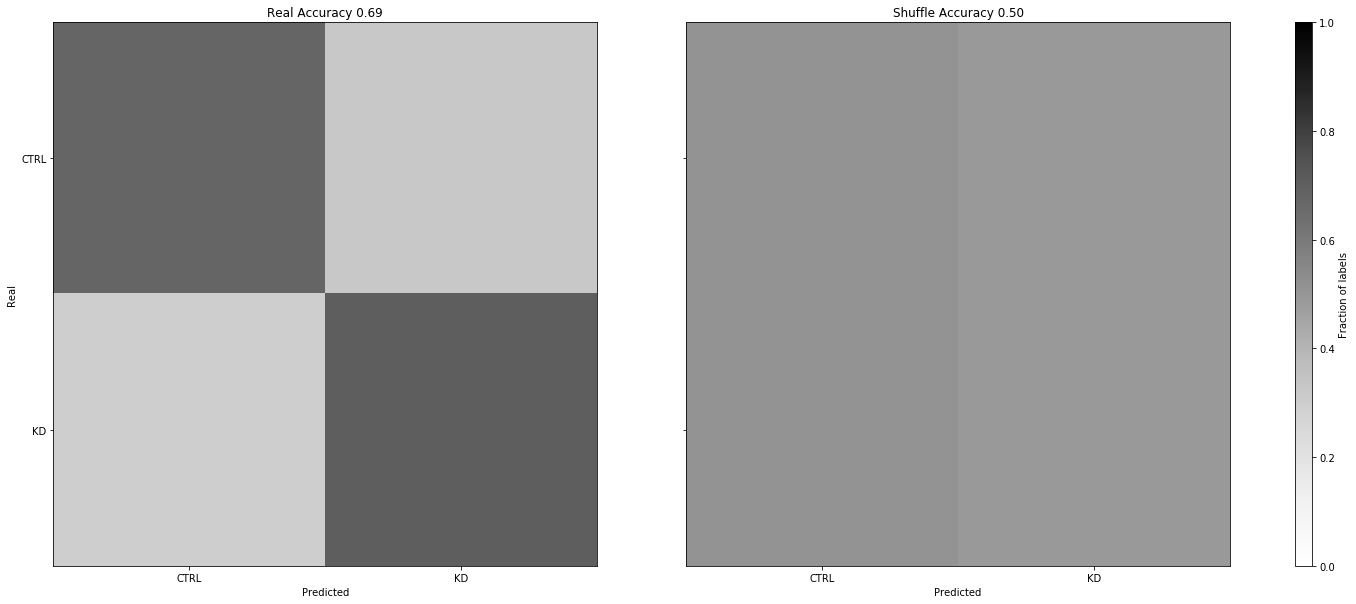

In [20]:
plot_cm(y_true, y_pred, y_tshuff, y_pshuff, 'logistic_regression')